# Notebook to segment fetal images using different methods

Class description:

    Label: 0 (Background)
    Label: 1 (third_sylvian, line)
    Label: 2 (third_midline, line)
    Label: 3 (third_cavum, area)
    Label: 4 (third_cerebellum, area)

Channel description:

    Channel: 1 (grayscale)

In [1]:
import os
import time
import warnings
from time import strftime
from functools import partial

from PIL import Image

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from skimage import io as skio
from scipy.special import expit, softmax

import torch
from torch.utils.data import DataLoader
import torch.nn.functional as func

from datasets import FetalDataset
from models import FCN_ResNet50, FCN_ResNet101, LRASPP_MobileNet
from models import DeeplabV3_MobileNet, DeeplabV3_ResNet50, Unet2D
from utils import color_codes, time_to_string, normalise

from pathlib import Path

The imports can be divided into a few different groups:
- **General packages**: This group include basic python libraries (included with any distribution of python) to perform basic operations relations to files, measuring execution time or function utilities.
- **Image packages**: This dataset uses a specific type of GeoTIFF files (?). To open them we will be using image libraries focused on TIFF files.
- **Plotting tools**: matplotlib (and seaborn) is the most commonly useful visualisation tool for plotting results.
- **Scientific tools**: This larger group includes numpy (equivalent to matlab array processing), scipy (numpy extension for scientific projects) and sklearn (and its image analysis extension). These packages provide tools to manipulate data.
- **Autodifferentiable packages**: For this notebook we will be using pytorch as our tool to build and train deep learning models.
- **Tools from the repository**: To simplify our networks, some of the meaty code is stored on a relevant file including dataset implementations, models based on torchvision and other utils.

# Reading Data
  

In [2]:
path = './data/Final_round'

lDict = {"third_sylvian" : (1,False), "third_midline": (2,False), "third_cavum": (3,True), "third_cerebellum":(4,True)} 

FRds = FetalDataset(path,lDict)

In [3]:
def visualize_fetal_dataset(dataset, n=3):
    """
    Display `n` samples from a FetalDataset instance.
    
    Each sample shows:
    - The ultrasound image
    - The corresponding label mask
    """
    for i in range(min(n, len(dataset))):
        us_image, label_mask = dataset[i]

        fig, axes = plt.subplots(1, 3, figsize=(10, 5))

        axes[0].imshow(us_image, cmap='gray')
        axes[0].set_title("Ultrasound Image")
        axes[0].axis("off")

        axes[1].imshow(label_mask, cmap='tab10', vmin=0)
        axes[1].set_title("Label Mask")
        axes[1].axis("off")

        axes[2].imshow(us_image, cmap='gray')
        axes[2].imshow(label_mask, cmap='tab10', vmin=0, alpha = 0.2)
        axes[2].set_title("overlay")
        axes[2].axis("off")

        plt.tight_layout()
        plt.show()

TypeError: Invalid shape (3, 600, 800) for image data

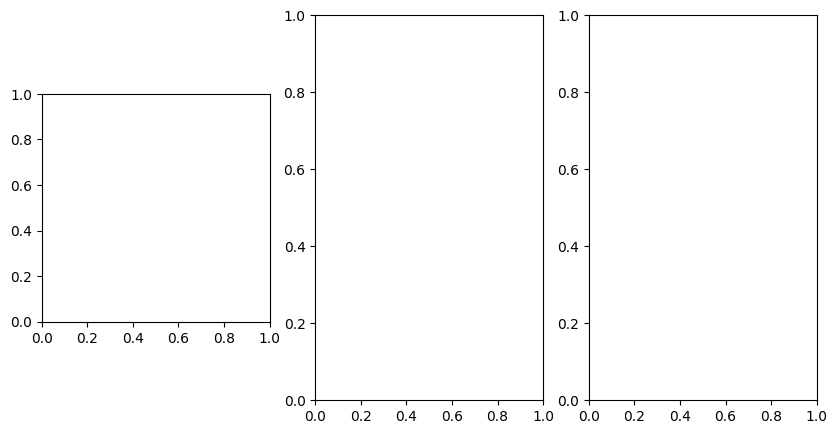

In [4]:
visualize_fetal_dataset(FRds)

In [8]:
def run_segmentation_experiments(
    master_seed, network_name, display_name, experiment_name, network_f, training_data, testing_data,
    weight_path, maps_path, classes=None, epochs=10, patience=5,
    n_seeds=30, n_inputs=3, n_classes=2, train_batch=4, test_batch=10, saliency_batch=4, verbose=1
):
    
    training_set, validation_set = training_data.breakTrainValid(0.8)
    testing_set = testing_data

    # make paths if they did not exist
    for d in [weight_path,maps_path]: Path(d).mkdir(parents=True, exist_ok=True)
    
    # Choosing random runs.
    np.random.seed(master_seed)
    seeds = np.random.randint(0, 100000, n_seeds)
    c = color_codes()

    dsc_list = []
    class_dsc_list = []
    # Main loop to run each independent random experiment.
    for test_n, seed in enumerate(seeds):
        acc = 0
        np.random.seed(seed)
        torch.manual_seed(seed)
        
        # The network will only be instantiated with the number of output classes
        # (2 in this notebok). Therefore, networks that need extra parameters (like ViT)
        # will need to be passed as a partial function.
        net = network_f(n_inputs=n_inputs, n_outputs=n_classes)
               
        # This is a leftover from legacy code. If init is set to True (the default option),
        # a first validation epoch will be run to determine the loss before training.
        net.init = False
        
        # The number of parameters is only captured for debugging and printing.
        n_param = sum(
            p.numel() for p in net.parameters() if p.requires_grad
        )

        if verbose > 1:
            print(
                '{:}[{:}] {:}Starting experiment {:}(seed {:05d} - {:} {:}[{:,} parameters]{:})'
                '{:} [{:02d}/{:02d}] {:}for {:} segmentation{:}'.format(
                    c['clr'] + c['c'], strftime("%m/%d/%Y - %H:%M:%S"), c['g'],
                    c['nc'] + c['y'], seed, c['b'] + display_name,
                    c['nc'], n_param, c['y'],
                    c['nc'] + c['c'], test_n + 1, len(seeds),
                    c['nc'] + c['g'], c['b'] + experiment_name + c['nc'] + c['g'], c['nc']
                )
            )
        
        training_loader = DataLoader(
            training_set, train_batch, True
        )
        validation_loader = DataLoader(
            validation_set, test_batch
        )
        model_path = os.path.join(
            weight_path, '{:}-balanced_s{:05d}_p.pt'.format(network_name, seed)
        )
        
        # For efficiency, we only run the code once. If the weights are
        # stored on disk, we do not need to train again.
        try:
            net.load_model(model_path)
        except IOError:
            net.train()
            print(''.join([' '] * 200), end='\r')
            net.fit(training_loader, validation_loader, epochs=epochs, patience=patience)
            net.save_model(model_path)
        
        if verbose > 2:
            print(''.join([' '] * 200), end='\r')
            print(
                '{:}[{:}] {:}Testing {:}(seed {:05d}){:} [{:02d}/{:02d}] '
                '{:}for {:} segmentation <{:03d} samples>{:}'.format(
                    c['clr'] + c['c'], strftime("%m/%d/%Y - %H:%M:%S"), c['g'],
                    c['nc'] + c['y'], seed, c['nc'] + c['c'], test_n + 1, len(seeds),
                    c['nc'] + c['g'], c['b'] + experiment_name + c['nc'] + c['g'], 
                    len(training_set), c['nc']
                )
            )
        
        # Metric evaluation.
        net.eval()
        with torch.no_grad():
            mosaic_dsc = []
            mosaic_class_dsc = []
            # Intermediate buffers for class metrics.
            #for input_mosaic, mask_i in zip(testing_mosaics, testing_masks):
            for input_mosaic, mask_i in testing_data:
                pred_map = net.inference(
                    np.expand_dims(
                        normalise(input_mosaic).astype(np.float32),
                        axis=0
                    )
                )[0]
            
                pred_y = np.argmax(pred_map, axis=0).astype(np.uint8)
                y = mask_i.astype(np.uint8)
                intersection = np.stack([
                    2 * np.sum(np.logical_and(pred_y == lab, y == lab))
                    for lab in range(n_classes)
                ])
                card_pred_y = np.stack([
                    np.sum(pred_y == lab) for lab in range(n_classes)
                ])
                card_y = np.stack([
                    np.sum(y == lab) for lab in range(n_classes)
                ])
                dsc_k = intersection / (card_pred_y + card_y)
                dsc = np.nanmean(dsc_k)
                mosaic_dsc.append(dsc)
                mosaic_class_dsc.append(dsc_k.tolist())

                for i, map_i in enumerate(softmax(pred_map, axis=0)):
                    map_path = os.path.join(
                        maps_path, '{:}-balanced_s{:05d}_map_{:02d}.png'.format(
                            network_name, seed, i
                        )
                    )
                    final_map = (255 * map_i).astype(np.uint8)
                    skio.imsave(map_path, final_map.astype(np.uint8))
                map_path = os.path.join(
                    maps_path, '{:}-balanced_s{:05d}_masks.png'.format(
                        network_name, seed
                    )
                )
                final_map = (255 * (pred_y / (n_classes - 1))).astype(np.uint8)
                skio.imsave(map_path, final_map.astype(np.uint8))
                
                dsc = np.nanmean(mosaic_dsc, axis=0)
                class_dsc = np.nanmean(mosaic_class_dsc, axis=0)
        if verbose > 2:
            print(''.join([' '] * 200), end='\r')
            print(
                '{:}[{:}] {:}DSC{:} (seed {:05d}){:} [{:02d}/{:02d}] {:}'
                '{:5.3f}{:}'.format(
                    c['clr'] + c['c'], strftime("%m/%d/%Y - %H:%M:%S"), c['g'],
                    c['nc'] + c['y'], seed, c['nc'] + c['c'], test_n + 1, len(seeds),
                    c['nc'] + c['b'], dsc, c['nc']
                )
            )

            class_dsc_s = ', '.join([
            '{:} {:5.3f}'.format(k, dsc_k)
                for k, dsc_k in zip(classes, class_dsc)
            ])
            print(
                '{:}[{:}] {:}Class DSC{:} (seed {:05d}){:} [{:02d}/{:02d}] {:}'.format(
                    c['clr'] + c['c'], strftime("%m/%d/%Y - %H:%M:%S"), c['g'],
                    c['nc'] + c['y'], seed, c['nc'] + c['c'], test_n + 1, len(seeds),
                    c['nc'] + c['b'] + class_dsc_s + c['nc']
                )
            )
        elif verbose > 1:
            print(''.join([' '] * 200), end='\r')
            print(
                '{:}Seed {:05d} {:} [{:,} parameters] '
                '{:}[{:02d}/{:02d}] {:} {:5.3f}{:}'.format(
                    c['y'], seed, c['b'] + display_name + c['nc'], n_param,
                    c['c'], test_n + 1, len(seeds),
                    c['nc'] + c['g'] + c['b'] + experiment_name + c['nc'] + c['b'],
                    dsc, c['nc']
                )
            )
        elif verbose > 0:
            print(''.join([' '] * 200), end='\r')
            print(
                '{:}Seed {:05d} {:} [{:,} parameters] '
                '{:}[{:02d}/{:02d}] {:} {:5.3f}{:}'.format(
                    c['y'], seed, c['b'] + display_name + c['nc'], n_param,
                    c['c'], test_n + 1, len(seeds),
                    c['nc'] + c['g'] + c['b'] + experiment_name + c['nc'] + c['b'],
                    dsc, c['nc']
                ), end='\r'
            )
        net = None
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
        dsc_list.append(mosaic_dsc)
        class_dsc_list.append(mosaic_class_dsc)
    
    # Metrics for all the runs.
    if verbose > 0:
        print(''.join([' '] * 200), end='\r')
        print(
            '{:}[{:}] {:} Mean DSC{:} {:5.3f}{:}'.format(
                c['clr'] + c['c'], strftime("%m/%d/%Y - %H:%M:%S"),
                c['nc'] + c['y'] + c['b'] + display_name + c['nc'] + c['g'],
                c['nc'] + c['b'], np.nanmean(dsc_list), c['nc']
            )
        )
        class_dsc_s = ', '.join([
            '{:} {:5.3f}'.format(k, dsc_k)
            for k, dsc_k in zip(
                classes, np.nanmean(class_dsc_list, axis=(0, 1))
            )
        ])
        print(
            '{:}[{:}] {:} Mean class DSC {:}'.format(
                c['clr'] + c['c'], strftime("%m/%d/%Y - %H:%M:%S"), 
                c['nc'] + c['y'] + c['b'] + display_name + c['nc'] + c['g'],
                c['nc'] + c['b'] + class_dsc_s + c['nc']
            )
        )
        
    return dsc_list, class_dsc_list

In [9]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

master_seed = 42

train_batch = 8
test_batch = 8
epochs = 5
patience = 50
name = 'fetal us'
classes = ['background', "third_sylvian", "third_midline", "third_cavum", "third_cerebellum"]

d_path = "./data"
path_training = './data/training'
path_testing = './data/testing'

lDict = {"third_sylvian" : (1,False), "third_midline": (2,False), "third_cavum": (3,True), "third_cerebellum":(4,True)} 

training_set = FetalDataset(path_training, lDict)
testing_set = FetalDataset(path_testing, lDict)
# The experiments are run next. We capture some warnings related to
# image loading to clean the debugging console.
    
# Unet [64, 64, 256, 256, 512, 512]
unet_dsc, unet_k_dsc = run_segmentation_experiments(
    master_seed, 'unet2d', 'Unet 2D', name,
    partial(Unet2D, lr=1e-4, conv_filters=[64, 64, 256, 256, 512, 512]),
    training_set, testing_set, 
    os.path.join(d_path, 'Weights'), os.path.join(d_path, 'Predictions'),
    classes, n_inputs = 3, n_classes = 5, epochs=epochs, patience=patience,
    train_batch=train_batch, test_batch=test_batch, verbose=1
)

# FCN ResNet50
fcn50_dsc, fcn50_k_dsc = run_segmentation_experiments(
    master_seed, 'fcn-resnet50', 'FCN ResNet50', name,
    partial(FCN_ResNet50, lr=1e-4, pretrained=True),
    training_set, testing_set,
    os.path.join(d_path, 'Weights'), os.path.join(d_path, 'Predictions'),
    classes, n_inputs = 3, n_classes = 5, epochs=epochs, patience=patience,
    train_batch=train_batch, test_batch=test_batch, verbose=1
)

# FCN ResNet101
fcn101_dsc, fcn101_k_dsc = run_segmentation_experiments(
    master_seed, 'fcn-resnet101', 'FCN ResNet101', name,
    partial(FCN_ResNet101, lr=1e-4, pretrained=True),
    training_set, testing_set,
    os.path.join(d_path, 'Weights'), os.path.join(d_path, 'Predictions'),
    classes, n_inputs = 3, n_classes = 5, epochs=epochs, patience=patience,
    train_batch=train_batch, test_batch=test_batch, verbose=1
)

# DeeplapV3 MobileNet
dl3mn_dsc, dl3mn_k_dsc = run_segmentation_experiments(
    master_seed, 'deeplab3-mobilenet', 'DeeplabV3 MobileNet', name,
    partial(DeeplabV3_MobileNet, lr=1e-4, pretrained=True),
    training_set, testing_set,
    os.path.join(d_path, 'Weights'), os.path.join(d_path, 'Predictions'),
    classes, n_inputs = 3, n_classes = 5, epochs=epochs, patience=patience,
    train_batch=train_batch, test_batch=test_batch, verbose=1
)

# DeeplapV3 ResNet50
dl3rn_dsc, dl3rn_k_dsc = run_segmentation_experiments(
    master_seed, 'deeplab3-resnet50', 'DeeplabV3 ResNet50', name,
    partial(DeeplabV3_ResNet50, lr=1e-4, pretrained=True),
    training_set, testing_set,
    os.path.join(d_path, 'Weights'), os.path.join(d_path, 'Predictions'),
    classes, n_inputs = 3, n_classes = 5, epochs=epochs, patience=patience,
    train_batch=train_batch, test_batch=test_batch, verbose=1
)

# L-RASPP ResNet50
lraspp_dsc, lraspp_k_dsc = run_segmentation_experiments(
    master_seed, 'lraspp-mobilenet', 'Lite R-ASPP MobileNet', name,
    partial(LRASPP_MobileNet, lr=1e-4, pretrained=True),
    training_set, testing_set,
    os.path.join(d_path, 'Weights'), os.path.join(d_path, 'Predictions'),
    classes, n_inputs = 3, n_classes = 5, epochs=epochs, patience=patience,
    train_batch=train_batch, test_batch=test_batch, verbose=1
)

/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s15795_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s15795_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s15795_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s15795_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s15795_masks.png 

Seed 15795 Unet 2D [13,273,989 parameters] [01/30] fetal us 0.198                                                                                            

/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s00860_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s00860_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s00860_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s00860_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s00860_masks.png 

Seed 00860 Unet 2D [13,273,989 parameters] [02/30] fetal us 0.198                                                                                            

/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s76820_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s76820_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s76820_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s76820_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s76820_masks.png 

Seed 06265 Unet 2D [13,273,989 parameters] [05/30] fetal us 0.185                                                                                            

/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s82386_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s82386_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s82386_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s82386_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s82386_masks.png 

Seed 82386 Unet 2D [13,273,989 parameters] [06/30] fetal us 0.198                                                                                            

/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s37194_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s37194_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s37194_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s37194_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s37194_masks.png 

Seed 37194 Unet 2D [13,273,989 parameters] [07/30] fetal us 0.198                                                                                            

/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s87498_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s87498_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s87498_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s87498_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s87498_masks.png 

Seed 87498 Unet 2D [13,273,989 parameters] [08/30] fetal us 0.198                                                                                            

/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s44131_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s44131_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s44131_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s44131_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s44131_masks.png 

Seed 44131 Unet 2D [13,273,989 parameters] [09/30] fetal us 0.198                                                                                            

/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s60263_map_03.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s60263_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s60263_map_03.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s60263_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s60263_map_03.p

Seed 60263 Unet 2D [13,273,989 parameters] [10/30] fetal us 0.198                                                                                            

/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s16023_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s16023_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s16023_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s16023_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s16023_masks.png 

Seed 16023 Unet 2D [13,273,989 parameters] [11/30] fetal us 0.198                                                                                            

/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s41090_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s41090_map_03.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s41090_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s41090_map_03.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s41090_masks.pn

Seed 41090 Unet 2D [13,273,989 parameters] [12/30] fetal us 0.197                                                                                            

/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s67221_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s67221_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s67221_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s67221_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s67221_masks.png 

Seed 64820 Unet 2D [13,273,989 parameters] [14/30] fetal us 0.188                                                                                            

/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s00769_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s00769_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s00769_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s00769_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s00769_masks.png 

Seed 00769 Unet 2D [13,273,989 parameters] [15/30] fetal us 0.198                                                                                            

/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s59735_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s59735_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s59735_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s59735_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s59735_masks.png 

Seed 59735 Unet 2D [13,273,989 parameters] [16/30] fetal us 0.198                                                                                            

/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s62955_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s62955_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s62955_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s62955_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s62955_masks.png 

Seed 62955 Unet 2D [13,273,989 parameters] [17/30] fetal us 0.198                                                                                            

/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s64925_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s64925_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s64925_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s64925_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s64925_masks.png 

Seed 64925 Unet 2D [13,273,989 parameters] [18/30] fetal us 0.198                                                                                            

/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s67969_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s67969_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s67969_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s67969_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s67969_masks.png 

Seed 67969 Unet 2D [13,273,989 parameters] [19/30] fetal us 0.198                                                                                            

/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s05311_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s05311_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s05311_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s05311_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s05311_masks.png 

Seed 05311 Unet 2D [13,273,989 parameters] [20/30] fetal us 0.198                                                                                            

/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s83104_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s83104_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s83104_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s83104_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s83104_masks.png 

Seed 83104 Unet 2D [13,273,989 parameters] [21/30] fetal us 0.198                                                                                            

/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s53707_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s53707_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s53707_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s53707_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s53707_masks.png 

Seed 53707 Unet 2D [13,273,989 parameters] [22/30] fetal us 0.198                                                                                            

/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s85305_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s85305_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s85305_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s85305_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s85305_masks.png 

Seed 85305 Unet 2D [13,273,989 parameters] [23/30] fetal us 0.198                                                                                            

/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s28693_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s28693_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s28693_masks.png is a low contrast image
  return func(*args, **kwargs)


Seed 28693 Unet 2D [13,273,989 parameters] [24/30] fetal us 0.195                                                                                            

/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s71932_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s71932_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s71932_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s71932_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s71932_masks.png 

Seed 71932 Unet 2D [13,273,989 parameters] [25/30] fetal us 0.197                                                                                            

/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s93016_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s93016_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s93016_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s93016_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s93016_masks.png 

Seed 93016 Unet 2D [13,273,989 parameters] [26/30] fetal us 0.198                                                                                            

/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s25658_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s25658_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s25658_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s25658_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s25658_masks.png 

Seed 25658 Unet 2D [13,273,989 parameters] [27/30] fetal us 0.198                                                                                            

/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s84478_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s84478_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s84478_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s84478_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s84478_masks.png 

Seed 84478 Unet 2D [13,273,989 parameters] [28/30] fetal us 0.198                                                                                            

/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s18431_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s18431_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s18431_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s18431_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/unet2d-balanced_s18431_masks.png 

[07/29/2025 - 15:23:55] Unet 2D Mean DSC 0.196                                                                                                                
[07/29/2025 - 15:23:55] Unet 2D Mean class DSC background 0.981, third_sylvian 0.000, third_midline 0.000, third_cavum 0.000, third_cerebellum 0.001


/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/fcn-resnet50-balanced_s15795_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/fcn-resnet50-balanced_s15795_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/fcn-resnet50-balanced_s15795_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/fcn-resnet50-balanced_s15795_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/fcn-resne

Seed 15795 FCN ResNet50 [35,309,898 parameters] [01/30] fetal us 0.200                                                                                       

/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/fcn-resnet50-balanced_s00860_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/fcn-resnet50-balanced_s00860_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/fcn-resnet50-balanced_s00860_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/fcn-resnet50-balanced_s00860_masks.png is a low contrast image
  return func(*args, **kwargs)
/home/yago/anaconda3/envs/fetal/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ./data/Predictions/fcn-resne

           Epoch num |  train  |   val   |   xent   |   dsc    |   mIoU   |  drp  |                                                                                                                  
           ----------|---------|---------|----------|----------|----------|-------|


OutOfMemoryError: CUDA out of memory. Tried to allocate 236.00 MiB. GPU 0 has a total capacity of 23.52 GiB of which 107.19 MiB is free. Including non-PyTorch memory, this process has 22.08 GiB memory in use. Of the allocated memory 21.52 GiB is allocated by PyTorch, and 125.60 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)